# $Telco Project Data$

### Imports

In [19]:
import pandas as pd
import numpy as np
import wrangle as w
# to see all columns in wide datasets
pd.set_option('display.max_columns', None)

import seaborn as sns

# train test split from sklearn
from sklearn.model_selection import train_test_split


In [2]:
# acquire telco data 
df = w.get_telco_data()

In [3]:
df.columns

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [4]:
df.dtypes

payment_type_id               int64
internet_service_type_id      int64
contract_type_id              int64
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
paperless_billing            object
monthly_charges             float64
total_charges                object
churn                        object
contract_type                object
internet_service_type        object
payment_type                 object
dtype: object

In [5]:
df.shape


(7043, 24)

In [6]:
df.total_charges.value_counts()

           11
20.2       11
19.75       9
19.9        8
20.05       8
           ..
2387.75     1
6302.8      1
2058.5      1
829.55      1
3707.6      1
Name: total_charges, Length: 6531, dtype: int64

# prepare

In [12]:
# cleaning data
df = w.prep_telco(df)

In [13]:
df

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,phone_service_No,phone_service_Yes,multiple_lines_No,multiple_lines_No phone service,multiple_lines_Yes,online_security_No,online_security_No internet service,online_security_Yes,online_backup_No,online_backup_No internet service,online_backup_Yes,device_protection_No,device_protection_No internet service,device_protection_Yes,tech_support_No,tech_support_No internet service,tech_support_Yes,streaming_tv_No,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_No,paperless_billing_Yes,churn_No,churn_Yes,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.60,593.30,No,One year,DSL,Mailed check,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1
1,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.90,542.40,No,Month-to-month,DSL,Mailed check,0,1,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,1
2,Male,0,No,No,4,Yes,No,No,No,Yes,No,No,No,Yes,73.90,280.85,Yes,Month-to-month,Fiber optic,Electronic check,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,No,Yes,Yes,Yes,98.00,1237.85,Yes,Month-to-month,Fiber optic,Electronic check,0,1,0,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0
4,Female,1,Yes,No,3,Yes,No,No,No,No,Yes,Yes,No,Yes,83.90,267.40,Yes,Month-to-month,Fiber optic,Mailed check,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,0,No,No,13,Yes,No,Yes,No,No,Yes,No,No,No,55.15,742.90,No,One year,DSL,Mailed check,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1
7039,Male,0,Yes,No,22,Yes,Yes,No,No,No,No,No,Yes,Yes,85.10,1873.70,Yes,Month-to-month,Fiber optic,Electronic check,0,1,0,1,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0
7040,Male,0,No,No,2,Yes,No,No,Yes,No,No,No,No,Yes,50.30,92.75,No,Month-to-month,DSL,Mailed check,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1
7041,Male,0,Yes,Yes,67,Yes,No,Yes,No,Yes,Yes,No,Yes,No,67.85,4627.65,No,Two year,DSL,Mailed check,0,1,0,1,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,1


# prepare

# drop columns with unuseful information 'customer_id'
# drop columns with redundant information 'payment_type_id', 'internet_service_type_id', 'contract_type_id'
df = df.drop (columns = {'payment_type_id', 'internet_service_type_id', 'contract_type_id','customer_id'})

# remove 11 rows that have white space in the total_charges columns
df = df[df.total_charges != ' ']


# convert total_charges to a numeric type column
df.total_charges = df.total_charges.astype('float')

#columns with unuseful information
unuseful =['customer_id']
#columns with redundant information

redundant = ['payment_type_id', 'internet_service_type_id', 'contract_type_id']


df = df.drop (columns = {'payment_type_id', 'internet_service_type_id', 'contract_type_id','customer_id'})

#remove 11 observations in total_charges that have null values and convert to numeric type

df = df[df.total_charges != ' ']

df.total_charges = df.total_charges.astype('float')

df.dtypes

df


df[df.contract_type != 'Month-to-month']

df.isnull().sum()

df.head()

In [14]:
def train_validate_test(df, target):
    ''' This function takes in a dataframe and target variable to sratify and  splits the data into 
    train , validate, test'''
    
    train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df[target])
    train, validate = train_test_split(train, test_size=.25, random_state=123, stratify=train[target])
    
    return train, validate, test

In [15]:
df

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,phone_service_No,phone_service_Yes,multiple_lines_No,multiple_lines_No phone service,multiple_lines_Yes,online_security_No,online_security_No internet service,online_security_Yes,online_backup_No,online_backup_No internet service,online_backup_Yes,device_protection_No,device_protection_No internet service,device_protection_Yes,tech_support_No,tech_support_No internet service,tech_support_Yes,streaming_tv_No,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_No,paperless_billing_Yes,churn_No,churn_Yes,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.60,593.30,No,One year,DSL,Mailed check,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1
1,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.90,542.40,No,Month-to-month,DSL,Mailed check,0,1,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,1
2,Male,0,No,No,4,Yes,No,No,No,Yes,No,No,No,Yes,73.90,280.85,Yes,Month-to-month,Fiber optic,Electronic check,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,No,Yes,Yes,Yes,98.00,1237.85,Yes,Month-to-month,Fiber optic,Electronic check,0,1,0,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0
4,Female,1,Yes,No,3,Yes,No,No,No,No,Yes,Yes,No,Yes,83.90,267.40,Yes,Month-to-month,Fiber optic,Mailed check,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,0,No,No,13,Yes,No,Yes,No,No,Yes,No,No,No,55.15,742.90,No,One year,DSL,Mailed check,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1
7039,Male,0,Yes,No,22,Yes,Yes,No,No,No,No,No,Yes,Yes,85.10,1873.70,Yes,Month-to-month,Fiber optic,Electronic check,0,1,0,1,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0
7040,Male,0,No,No,2,Yes,No,No,Yes,No,No,No,No,Yes,50.30,92.75,No,Month-to-month,DSL,Mailed check,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1
7041,Male,0,Yes,Yes,67,Yes,No,Yes,No,Yes,Yes,No,Yes,No,67.85,4627.65,No,Two year,DSL,Mailed check,0,1,0,1,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,1


In [16]:
# split data
telco_train, validate, test = train_validate_test(df,'churn')
telco_train.shape,validate.shape, test.shape

#seperate target
x_train = telco_train.drop(columns=['churn','churn_No','churn_Yes'])
y_train = telco_train.churn_Yes

x_validate = validate.drop(columns=['churn','churn_No','churn_Yes'])
y_validate = validate.churn_Yes

x_test = test.drop(columns=['churn','churn_No','churn_Yes'])
y_test = test.churn_Yes

x_train, x_validate, x_test = w.impute_mean_total_charges(x_train, x_validate, x_test)

# How often does churn occur?

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='churn_Yes', ylabel='count'>

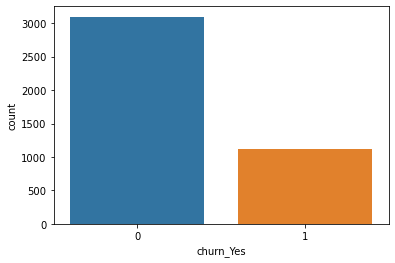

In [21]:
sns.countplot(y_train)

In [ ]:

# prepare data
telco_df = w.prep_telco(df)

# drop columns
telco_df =telco_df.drop(columns={'customer_id',
                                    'dependents',
                                    'phone_service',
                                    'multiple_lines',
                                    'online_security',
                                    'online_backup',
                                    'device_protection', 
                                    'tech_support',
                                    'streaming_tv',
                                    'streaming_movies',
                                    'paperless_billing',
                                     'gender',
                                     'partner',
            
                                    'contract_type',
                                    'internet_service_type',
                                    'payment_type'})
# split data
telco_train, validate, test = w.split_telco_data(telco_df)
telco_train.shape,validate.shape, test.shape

#seperate target
x_train = telco_train.drop(columns=['churn','churn_No','churn_Yes'])
y_train = telco_train.churn_Yes

x_validate = validate.drop(columns=['churn','churn_No','churn_Yes'])
y_validate = validate.churn_Yes

x_test = test.drop(columns=['churn','churn_No','churn_Yes'])
y_test = test.churn_Yes

x_train, x_validate, x_test = w.impute_mean_total_charges(x_train, x_validate, x_test)

In [ ]:
x_train
